# LSTM-Autoencoder Evaluation on New TEP Dataset

This notebook evaluates the trained LSTM-Autoencoder model on the newly generated independent TEP dataset.

**Purpose**: Test model generalization on completely unseen data generated from `tep-sim`.

**Model**: LSTM-Autoencoder (binary anomaly detection)

**Evaluation Dataset**: `data/new_binary_eval.csv` (generated by notebook 03)

## Configuration & Imports

In [1]:
import os
import json
import time
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = Path('../data')
MODEL_DIR = Path('../outputs/models')
METRICS_DIR = Path('../outputs/metrics')
FIGURES_DIR = Path('../outputs/figures')

METRICS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

QUICK_MODE = False
if (DATA_DIR / 'new_binary_eval_quick.csv').exists():
    if not (DATA_DIR / 'new_binary_eval.csv').exists():
        QUICK_MODE = True
    else:
        quick_mtime = (DATA_DIR / 'new_binary_eval_quick.csv').stat().st_mtime
        full_mtime = (DATA_DIR / 'new_binary_eval.csv').stat().st_mtime
        QUICK_MODE = quick_mtime > full_mtime

if os.environ.get('QUICK_MODE', '').lower() in ('true', '1', 'yes'):
    QUICK_MODE = True

FILE_SUFFIX = '_quick' if QUICK_MODE else ''

print('='*60)
print('LSTM-Autoencoder Evaluation on New TEP Dataset')
if QUICK_MODE:
    print('QUICK MODE - Using limited test dataset')
print(f'Device: {device}')
print('='*60)

LSTM-Autoencoder Evaluation on New TEP Dataset
QUICK MODE - Using limited test dataset
Device: cuda


## Define Model Architecture

In [2]:
class LSTMAutoencoder(nn.Module):
    """LSTM Autoencoder for anomaly detection."""
    def __init__(self, input_size, hidden_size, num_layers, latent_size, dropout=0.0):
        super().__init__()
        
        self.encoder = nn.LSTM(
            input_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.encoder_fc = nn.Linear(hidden_size, latent_size)
        
        self.decoder_fc = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(
            hidden_size, hidden_size, num_layers,
            batch_first=True, dropout=dropout if num_layers > 1 else 0
        )
        self.output_fc = nn.Linear(hidden_size, input_size)
        
    def forward(self, x):
        _, (h, _) = self.encoder(x)
        latent = self.encoder_fc(h[-1])
        
        h_dec = self.decoder_fc(latent)
        h_dec = h_dec.unsqueeze(1).repeat(1, x.size(1), 1)
        dec_out, _ = self.decoder(h_dec)
        reconstruction = self.output_fc(dec_out)
        
        return reconstruction

print('Model class defined')

Model class defined


## Load Trained Model

In [3]:
print('\n[Step 1/5] Loading trained LSTM-Autoencoder model...')

model_path = MODEL_DIR / 'lstm_autoencoder_final.pt'
model_data = torch.load(model_path, map_location=device, weights_only=False)

features = model_data['features']
scaler_mean = model_data['scaler_mean']
scaler_scale = model_data['scaler_scale']
threshold = model_data['threshold']

hp = model_data['hyperparameters']
model = LSTMAutoencoder(
    input_size=len(features),
    hidden_size=hp['hidden_size'],
    num_layers=hp['num_layers'],
    latent_size=hp['latent_size'],
    dropout=hp['dropout']
)
model.load_state_dict(model_data['model_state_dict'])
model.to(device)
model.eval()

print(f'Model loaded from {model_path}')
print(f'  Features: {len(features)}')
print(f'  Anomaly threshold: {threshold:.6f}')

orig_metrics_path = METRICS_DIR / 'lstm_autoencoder_metrics.json'
with open(orig_metrics_path) as f:
    orig_metrics = json.load(f)
print('Original metrics loaded for comparison')


[Step 1/5] Loading trained LSTM-Autoencoder model...


Model loaded from ../outputs/models/lstm_autoencoder_final.pt
  Features: 52
  Anomaly threshold: 0.730866
Original metrics loaded for comparison


## Load New Evaluation Dataset

In [4]:
print('\n[Step 2/5] Loading new evaluation dataset...')
start_time = time.time()

eval_file = DATA_DIR / f'new_binary_eval{FILE_SUFFIX}.csv'
eval_data = pd.read_csv(eval_file)

# Create binary labels
eval_data['is_fault'] = (eval_data['faultNumber'] != 0).astype(int)

print(f'Dataset loaded in {time.time() - start_time:.2f}s')
print(f'  File: {eval_file.name}')
print(f'  Shape: {eval_data.shape}')
print(f'  Normal: {(eval_data["is_fault"] == 0).sum():,}')
print(f'  Fault: {(eval_data["is_fault"] == 1).sum():,}')


[Step 2/5] Loading new evaluation dataset...
Dataset loaded in 0.03s
  File: new_binary_eval_quick.csv
  Shape: (1099, 59)
  Normal: 402
  Fault: 697


## Create Sequence Dataset

In [5]:
class SequenceDataset(Dataset):
    def __init__(self, df, features, scaler_mean, scaler_scale, sequence_length=10):
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []
        
        for (fault, run), group in df.groupby(['faultNumber', 'simulationRun']):
            group = group.sort_values('sample')
            X = group[features].values
            y = group['is_fault'].values
            X = (X - scaler_mean) / scaler_scale
            
            for i in range(len(X) - sequence_length + 1):
                self.sequences.append(X[i:i+sequence_length])
                self.labels.append(y[i+sequence_length-1])
        
        self.sequences = np.array(self.sequences, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])

print('Dataset class defined')

Dataset class defined


In [6]:
print('\n[Step 3/5] Creating evaluation dataset...')
seq_len = model_data['hyperparameters']['sequence_length']

eval_dataset = SequenceDataset(
    eval_data, features, scaler_mean, scaler_scale, seq_len
)
eval_loader = DataLoader(eval_dataset, batch_size=512, shuffle=False, num_workers=0)

print(f'Evaluation sequences: {len(eval_dataset):,}')


[Step 3/5] Creating evaluation dataset...
Evaluation sequences: 396


## Compute Reconstruction Errors

In [7]:
print('\n[Step 4/5] Computing reconstruction errors...')
pred_start = time.time()

all_errors = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch = X_batch.to(device)
        recon = model(X_batch)
        errors = ((X_batch - recon) ** 2).mean(dim=(1, 2)).cpu().numpy()
        all_errors.extend(errors)
        all_labels.extend(y_batch.numpy())

recon_errors = np.array(all_errors)
y_eval = np.array(all_labels)
y_pred = (recon_errors > threshold).astype(int)

print(f'Predictions generated in {time.time() - pred_start:.2f}s')
print(f'  Reconstruction errors shape: {recon_errors.shape}')


[Step 4/5] Computing reconstruction errors...


Predictions generated in 0.26s
  Reconstruction errors shape: (396,)


## Compute Evaluation Metrics

In [8]:
print('\n[Step 5/5] Computing evaluation metrics...')

accuracy = accuracy_score(y_eval, y_pred)
precision = precision_score(y_eval, y_pred)
recall = recall_score(y_eval, y_pred)
f1 = f1_score(y_eval, y_pred)
auc = roc_auc_score(y_eval, recon_errors)
cm = confusion_matrix(y_eval, y_pred)

print('\n' + '='*60)
print('NEW EVALUATION DATASET RESULTS')
if QUICK_MODE:
    print('(Quick mode - limited samples)')
print('='*60)
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1 Score:  {f1:.4f}')
print(f'AUC-ROC:   {auc:.4f}')
print('='*60)


[Step 5/5] Computing evaluation metrics...

NEW EVALUATION DATASET RESULTS
(Quick mode - limited samples)
Accuracy:  0.4192
Precision: 0.1955
Recall:    0.7647
F1 Score:  0.3114
AUC-ROC:   0.7485


In [9]:
print('\nComparison with Original Test Set:')
print('-' * 50)
print(f'{"Metric":<15} {"Original":>12} {"New Eval":>12} {"Delta":>10}')
print('-' * 50)

comparisons = [
    ('Accuracy', orig_metrics['accuracy'], accuracy),
    ('Precision', orig_metrics['precision'], precision),
    ('Recall', orig_metrics['recall'], recall),
    ('F1', orig_metrics['f1_binary'], f1),
    ('AUC-ROC', orig_metrics['roc_auc'], auc),
]

for metric_name, orig_val, new_val in comparisons:
    delta = new_val - orig_val
    print(f'{metric_name:<15} {orig_val:>12.4f} {new_val:>12.4f} {delta:>+10.4f}')

print('-' * 50)


Comparison with Original Test Set:
--------------------------------------------------
Metric              Original     New Eval      Delta
--------------------------------------------------
Accuracy              0.9696       0.4192    -0.5504
Precision             0.9955       0.1955    -0.8000
Recall                0.9688       0.7647    -0.2041
F1                    0.9820       0.3114    -0.6706
AUC-ROC               0.9925       0.7485    -0.2440
--------------------------------------------------


## Visualizations

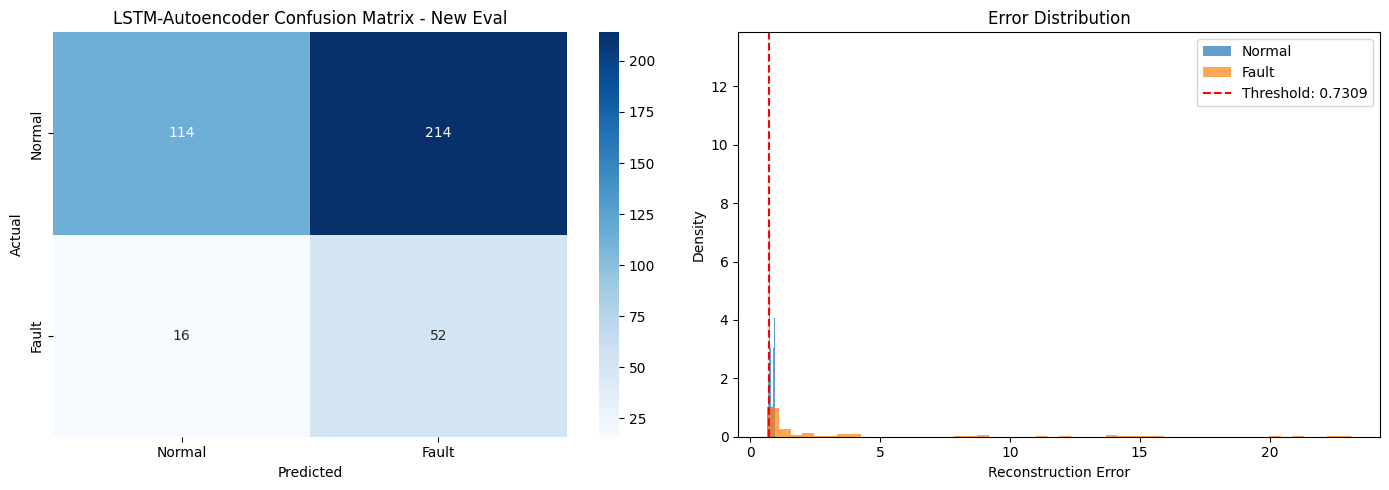

Saved to ../outputs/figures/lstm_autoencoder_new_eval_results_quick.png


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('LSTM-Autoencoder Confusion Matrix - New Eval')

# Error distribution
axes[1].hist(recon_errors[y_eval == 0], bins=50, alpha=0.7, label='Normal', density=True)
axes[1].hist(recon_errors[y_eval == 1], bins=50, alpha=0.7, label='Fault', density=True)
axes[1].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Density')
axes[1].set_title('Error Distribution')
axes[1].legend()

plt.tight_layout()
output_file = FIGURES_DIR / f'lstm_autoencoder_new_eval_results{FILE_SUFFIX}.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()
print(f'Saved to {output_file}')

## Save Results

In [11]:
new_eval_metrics = {
    'model': 'LSTM-Autoencoder',
    'dataset': f'new_binary_eval{FILE_SUFFIX}',
    'task': 'binary',
    'quick_mode': QUICK_MODE,
    'num_samples': len(y_eval),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_binary': float(f1),
    'roc_auc': float(auc),
    'threshold': float(threshold),
    'comparison_with_original': {
        'accuracy_delta': float(accuracy - orig_metrics['accuracy']),
        'f1_delta': float(f1 - orig_metrics['f1_binary']),
        'original_accuracy': orig_metrics['accuracy'],
        'original_f1': orig_metrics['f1_binary']
    }
}

output_file = METRICS_DIR / f'lstm_autoencoder_new_eval_metrics{FILE_SUFFIX}.json'
with open(output_file, 'w') as f:
    json.dump(new_eval_metrics, f, indent=2)
print(f'Saved metrics to {output_file}')

Saved metrics to ../outputs/metrics/lstm_autoencoder_new_eval_metrics_quick.json


In [12]:
print('\n' + '='*60)
print('LSTM-Autoencoder New Data Evaluation Complete!')
if QUICK_MODE:
    print('(Quick mode)')
print('='*60)
print(f'\nSummary:')
print(f'  Evaluation samples: {len(y_eval):,}')
print(f'  Accuracy: {accuracy:.4f} (original: {orig_metrics["accuracy"]:.4f})')
print(f'  F1: {f1:.4f} (original: {orig_metrics["f1_binary"]:.4f})')
print(f'  AUC-ROC: {auc:.4f}')
print('='*60)


LSTM-Autoencoder New Data Evaluation Complete!
(Quick mode)

Summary:
  Evaluation samples: 396
  Accuracy: 0.4192 (original: 0.9696)
  F1: 0.3114 (original: 0.9820)
  AUC-ROC: 0.7485
